# Setup & installs

In [3]:
!pip install tensorflow==2.16.1 opencv-python scikit-learn matplotlib

INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 MB 10.6 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 42.1 MB/s eta 0:00:0031m43.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 38.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml_dtypes 0.5.1
    Uninstalling ml_dtypes-0.5.1:
      Successfully uninstalled ml_dtypes-0.5.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0


# Importing Libraries

In [10]:
import os, json
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Paths and sanity check

In [11]:
# Change this if your notebook is not in the same folder as train/ and test/
DATA_ROOT = Path(".")
TRAIN_DIR = DATA_ROOT / "train"
TEST_DIR  = DATA_ROOT / "test"

assert TRAIN_DIR.exists(), f"Missing: {TRAIN_DIR}"
assert TEST_DIR.exists(),  f"Missing: {TEST_DIR}"

classes = sorted([p.name for p in TRAIN_DIR.iterdir() if p.is_dir()])
print("Found classes:", classes)

Found classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


#  Preprocessing & dataset loaders (train / val / test)

In [31]:
IMG_SIZE   = (160,160)
BATCH_SIZE = 64
VAL_SPLIT  = 0.10
SEED       = 42

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    color_mode="grayscale"   # <— force 1 channel
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    color_mode="grayscale"   # <— force 1 channel
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    color_mode="grayscale"   # <— force 1 channel
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Class mapping:", class_names)

Found 28709 files belonging to 7 classes.
Using 25839 files for training.
Found 28709 files belonging to 7 classes.
Using 2870 files for validation.
Found 7178 files belonging to 7 classes.
Class mapping: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


# Data augmentation & pipeline optimization

In [32]:
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.10),
    layers.RandomContrast(0.10),
], name="augmentation")

def to_rgb(x):
    # loader gives (H,W,1); convert to (H,W,3)
    return tf.image.grayscale_to_rgb(x)

def prepare(ds, training=False):
    ds = ds.map(lambda x, y: (to_rgb(x), y), num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

train_ds_p = prepare(train_ds, training=True)
val_ds_p   = prepare(val_ds,   training=False)
test_ds_p  = prepare(test_ds,  training=False)

# Model choice (MobileNetV2 transfer learning)

In [33]:
# Light, accurate, fast to train
base = keras.applications.MobileNetV2(
    include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,)
)
base.trainable = False  # start with frozen backbone

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.30)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Train (frozen backbone) + checkpoints & early stopping

In [34]:
os.makedirs("saved_models", exist_ok=True)
ckpt_path = "saved_models/fer_mobilenetv2.h5"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=4, restore_best_weights=True
    ),
]

history = model.fit(
    train_ds_p,
    validation_data=val_ds_p,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

print("Best checkpoint saved to:", ckpt_path)

# Save class names for inference
with open("saved_models/class_names.json", "w") as f:
    json.dump(class_names, f)

Epoch 1/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.2919 - loss: 1.9242
Epoch 1: val_accuracy improved from -inf to 0.44146, saving model to saved_models/fer_mobilenetv2.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 97s 237ms/step - accuracy: 0.2920 - loss: 1.9238 - val_accuracy: 0.4415 - val_loss: 1.4805
Epoch 2/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.4061 - loss: 1.5664
Epoch 2: val_accuracy improved from 0.44146 to 0.44704, saving model to saved_models/fer_mobilenetv2.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 102s 252ms/step - accuracy: 0.4062 - loss: 1.5664 - val_accuracy: 0.4470 - val_loss: 1.4645
Epoch 3/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.4319 - loss: 1.5024
Epoch 3: val_accuracy improved from 0.44704 to 0.44739, saving model to saved_models/fer_mobilenetv2.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 94s 232ms/step - accuracy: 0.4319 - loss: 1.5024 - val_accuracy: 0.4474 - val_loss: 1.4491
Epoch 4/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.4322 - loss: 1.4851
Epoch 4: val_accuracy improved from 0.44739 to 0.46411, saving model to saved_models/fer_mobilenetv2.h5


404/404 ━━━━━━━━━━━━━━━━━━━━ 97s 238ms/step - accuracy: 0.4322 - loss: 1.4851 - val_accuracy: 0.4641 - val_loss: 1.4266
Epoch 5/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.4361 - loss: 1.4827
Epoch 5: val_accuracy did not improve from 0.46411
404/404 ━━━━━━━━━━━━━━━━━━━━ 111s 275ms/step - accuracy: 0.4361 - loss: 1.4827 - val_accuracy: 0.4557 - val_loss: 1.4442
Epoch 6/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.4365 - loss: 1.4815
Epoch 6: val_accuracy did not improve from 0.46411
404/404 ━━━━━━━━━━━━━━━━━━━━ 108s 268ms/step - accuracy: 0.4365 - loss: 1.4815 - val_accuracy: 0.4582 - val_loss: 1.4526
Epoch 7/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.4368 - loss: 1.4769
Epoch 7: val_accuracy did not improve from 0.46411
404/404 ━━━━━━━━━━━━━━━━━━━━ 107s 264ms/step - accuracy: 0.4368 - loss: 1.4768 - val_accuracy: 0.4307 - val_loss: 1.5117
Epoch 8/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.4436 - loss: 1.4737
Epoch 8: val

404/404 ━━━━━━━━━━━━━━━━━━━━ 121s 300ms/step - accuracy: 0.4436 - loss: 1.4737 - val_accuracy: 0.4648 - val_loss: 1.4354
Epoch 9/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.4362 - loss: 1.4751
Epoch 9: val_accuracy did not improve from 0.46481
404/404 ━━━━━━━━━━━━━━━━━━━━ 136s 336ms/step - accuracy: 0.4362 - loss: 1.4751 - val_accuracy: 0.4641 - val_loss: 1.4538
Epoch 10/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.4407 - loss: 1.4820
Epoch 10: val_accuracy did not improve from 0.46481
404/404 ━━━━━━━━━━━━━━━━━━━━ 155s 384ms/step - accuracy: 0.4407 - loss: 1.4820 - val_accuracy: 0.4537 - val_loss: 1.4537
Epoch 11/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.4444 - loss: 1.4649
Epoch 11: val_accuracy did not improve from 0.46481
404/404 ━━━━━━━━━━━━━━━━━━━━ 171s 422ms/step - accuracy: 0.4444 - loss: 1.4649 - val_accuracy: 0.4620 - val_loss: 1.4293
Epoch 12/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.4424 - loss: 1.4712
Epoch 

In [35]:
import numpy as np

train_labels = []
for _, y in train_ds:
    train_labels.append(y.numpy())
train_labels = np.concatenate(train_labels)

unique, counts = np.unique(train_labels, return_counts=True)
total = train_labels.shape[0]
class_weights = {int(i): float(total / (len(unique)*c)) for i, c in zip(unique, counts)}
print("Class weights:", class_weights)

Class weights: {0: 1.02223365114531, 1: 9.297948902482908, 2: 1.0063483408630627, 3: 0.5660612964707429, 4: 0.8246840291076216, 5: 0.8497434885556433, 6: 1.3080388782018832}


2025-11-02 21:41:29.568713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [36]:
base.trainable = True
for layer in base.layers[:-40]:
    layer.trainable = False

loss_fn = keras.losses.SparseCategoricalCrossentropy()

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=loss_fn,
    metrics=["accuracy"]
)

callbacks_ft = [
    keras.callbacks.ModelCheckpoint("saved_models/fer_mobilenetv2.keras", save_best_only=True, monitor="val_accuracy", verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1),
]

history_ft = model.fit(
    train_ds_p,
    validation_data=val_ds_p,
    epochs=12,
    class_weight=class_weights,
    callbacks=callbacks_ft,
    verbose=1
)

print("Fine-tuned model saved to: saved_models/fer_mobilenetv2.keras")

Epoch 1/12
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.3671 - loss: 1.8773
Epoch 1: val_accuracy improved from -inf to 0.44495, saving model to saved_models/fer_mobilenetv2.keras
404/404 ━━━━━━━━━━━━━━━━━━━━ 188s 458ms/step - accuracy: 0.3673 - loss: 1.8767 - val_accuracy: 0.4449 - val_loss: 1.6457 - learning_rate: 1.0000e-04
Epoch 2/12
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.4972 - loss: 1.3198
Epoch 2: val_accuracy improved from 0.44495 to 0.47735, saving model to saved_models/fer_mobilenetv2.keras
404/404 ━━━━━━━━━━━━━━━━━━━━ 196s 484ms/step - accuracy: 0.4972 - loss: 1.3197 - val_accuracy: 0.4774 - val_loss: 1.5650 - learning_rate: 1.0000e-04
Epoch 3/12
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.5388 - loss: 1.1978
Epoch 3: val_accuracy improved from 0.47735 to 0.49303, saving model to saved_models/fer_mobilenetv2.keras
404/404 ━━━━━━━━━━━━━━━━━━━━ 171s 422ms/step - accuracy: 0.5388 - loss: 1.1978 - val_accuracy: 0.4930 - val_loss: 1.4470

Test accuracy: 0.6332


2025-11-02 22:18:37.285232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Classification report:
              precision    recall  f1-score   support

       angry       0.58      0.52      0.55       958
     disgust       0.65      0.59      0.62       111
        fear       0.52      0.35      0.42      1024
       happy       0.87      0.81      0.84      1774
     neutral       0.54      0.67      0.60      1233
         sad       0.50      0.57      0.53      1247
    surprise       0.71      0.77      0.74       831

    accuracy                           0.63      7178
   macro avg       0.62      0.61      0.61      7178
weighted avg       0.64      0.63      0.63      7178

Saved: saved_models/confusion_matrix.png


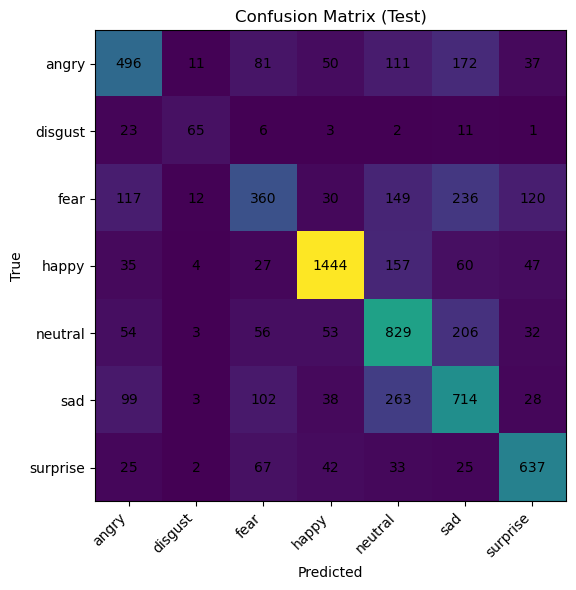

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Test accuracy
test_loss, test_acc = model.evaluate(test_ds_p, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

# Predictions → report + CM
y_true = np.concatenate([y.numpy() for _, y in test_ds])
y_pred = np.argmax(model.predict(test_ds_p, verbose=0), axis=1)

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(6.5, 6))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Confusion Matrix (Test)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticks(range(num_classes)); ax.set_yticks(range(num_classes))
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.savefig("saved_models/confusion_matrix.png")
print("Saved: saved_models/confusion_matrix.png")

In [38]:
# Reload to confirm it works
reloaded = tf.keras.models.load_model("saved_models/fer_mobilenetv2.keras")
print("Reloaded model ok. Same classes:", json.load(open("saved_models/class_names.json")))

Reloaded model ok. Same classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [39]:
pip install mediapipe

Note: you may need to restart the kernel to use updated packages.


In [46]:
# sanity check on test dataset sample to verify model is actually predicting diverse classes
import numpy as np

for images, labels in test_ds_p.take(1):
    pred = model.predict(images, verbose=0)
    preds = np.argmax(pred, axis=1)
    print("True labels:", [class_names[i] for i in labels.numpy()])
    print("Pred labels:", [class_names[i] for i in preds])

True labels: ['angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry']
Pred labels: ['angry', 'angry', 'sad', 'sad', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'sad', 'neutral', 'angry', 'angry', 'disgust', 'sad', 'angry', 'sad', 'angry', 'angry', 'angry', 'neutral', 'disgust', 'fear', 'angry', 'sad', 'sad', 'angry', 'sad', 'angry', 'sad', 'angry', 'angry', 'angry', 'angry', 'fear', 'angry', 'sad', 'angry', 'sad', 'fear', 'fear', 'angry', 

2025-11-02 22:25:01.492962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
import cv2, json, numpy as np, tensorflow as tf
import mediapipe as mp
from collections import deque
import math

# ---------------- Config ----------------
MODEL_PATH = "saved_models/fer_mobilenetv2.keras"
CLASS_PATH = "saved_models/class_names.json"

IMG_SIZE  = (160, 160)
SMOOTH_N  = 3        # default smoothing window (change with 1/3/5 keys)
PADDING   = 0.20     # padding around aligned face (change with +/-)
USE_CLAHE = True     # toggle with 'c'
MIRROR    = False    # toggle with 'm'
SHOW_BARS = True

# ------------- Load model/classes -------------
model = tf.keras.models.load_model(MODEL_PATH)
with open(CLASS_PATH) as f:
    class_names = json.load(f)
num_classes = len(class_names)

# ------------- MediaPipe FaceMesh -------------
mp_face = mp.solutions.face_mesh
mesh = mp_face.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.6,
    min_tracking_confidence=0.6
)

hist = deque(maxlen=max(1, SMOOTH_N))

# ------------- Helpers -------------
def clahe_gray(g):
    if not USE_CLAHE:
        return g
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(g)

def draw_probs(canvas, probs, labels, origin=(10,60), width=220, height=18, gap=8):
    x0,y0 = origin
    for i,(p,name) in enumerate(zip(probs, labels)):
        y = y0 + i*(height+gap)
        cv2.rectangle(canvas,(x0,y),(x0+width,y+height),(40,40,40),-1)
        cv2.rectangle(canvas,(x0,y),(x0+int(width*float(p)),y+height),(0,255,0),-1)
        cv2.putText(canvas,f"{name[:10]:10s} {p:.2f}",(x0+width+8,y+height-3),
                    cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,255),1,cv2.LINE_AA)

def align_and_crop(frame, lmks, padding=PADDING):
    """Rotate so eye line is horizontal, then square crop with padding."""
    h, w = frame.shape[:2]
    L = lmks[33]; R = lmks[263]  # outer eye corners
    lx, ly = int(L.x*w), int(L.y*h)
    rx, ry = int(R.x*w), int(R.y*h)
    dx, dy = rx - lx, ry - ly
    angle = math.degrees(math.atan2(dy, dx))
    center = ((lx + rx)//2, (ly + ry)//2)

    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(frame, M, (w, h), flags=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_REFLECT)

    xs = [int(p.x*w) for p in lmks]
    ys = [int(p.y*h) for p in lmks]
    x1, x2 = max(0, min(xs)), min(w, max(xs))
    y1, y2 = max(0, min(ys)), min(h, max(ys))

    fw, fh = x2 - x1, y2 - y1
    size = int(max(fw, fh) * (1.0 + padding))
    cx, cy = (x1 + x2)//2, (y1 + y2)//2
    sx1 = max(0, cx - size//2); sy1 = max(0, cy - size//2)
    sx2 = min(w, sx1 + size);   sy2 = min(h, sy1 + size)
    sx1 = max(0, sx2 - size);   sy1 = max(0, sy2 - size)

    crop = rotated[sy1:sy2, sx1:sx2]
    return crop, (sx1, sy1, sx2 - sx1, sy2 - sy1)

def preprocess_face(bgr_face):
    """Match training: GRAY -> (optional CLAHE) -> resize -> RGB; keep 0..255 (NO /255)."""
    gray = cv2.cvtColor(bgr_face, cv2.COLOR_BGR2GRAY)
    gray = clahe_gray(gray)
    face = cv2.resize(gray, IMG_SIZE, interpolation=cv2.INTER_AREA)
    face = cv2.cvtColor(face, cv2.COLOR_GRAY2RGB)
    face = face.astype("float32")           # keep 0..255; MobileNetV2 layer preprocesses inside
    return np.expand_dims(face, 0)

# ------------- Video loop -------------
cap = cv2.VideoCapture(0)
print("q/ESC: quit | 1/3/5: smoothing | c: CLAHE on/off | +/-: padding | m: mirror")

while True:
    ok, frame = cap.read()
    if not ok:
        break
    if MIRROR:
        frame = cv2.flip(frame, 1)

    h,w = frame.shape[:2]
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    res = mesh.process(rgb)

    probs = np.zeros(num_classes, dtype=np.float32)
    if res.multi_face_landmarks:
        lmks = res.multi_face_landmarks[0].landmark
        crop, (x,y,tw,th) = align_and_crop(frame, lmks, padding=PADDING)
        if crop.size > 0:
            inp = preprocess_face(crop)
            # Uncomment to confirm range: should be ~0..255
            # print(inp.min(), inp.max())
            p = model.predict(inp, verbose=0)[0]
            hist.append(p)
            probs = np.mean(hist, axis=0) if len(hist) > 1 else p

            idx = int(np.argmax(probs))
            label = f"{class_names[idx]} ({probs[idx]:.2f})"
            cv2.rectangle(frame, (x,y), (x+tw, y+th), (0,255,0), 2)
            cv2.putText(frame, label, (x, max(20, y-10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2, cv2.LINE_AA)

    if SHOW_BARS:
        overlay = frame.copy()
        draw_probs(overlay, probs, class_names, origin=(10,60))
        cv2.putText(overlay, f"N={SMOOTH_N}  CLAHE={'ON' if USE_CLAHE else 'OFF'}  Pad={PADDING:.2f}  Mirror={'ON' if MIRROR else 'OFF'}",
                    (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2, cv2.LINE_AA)
        frame = overlay

    cv2.imshow("FER (aligned)", frame)
    k = cv2.waitKey(1) & 0xFF
    if k in (27, ord('q')): break
    elif k == ord('1'): SMOOTH_N=1; hist=deque(maxlen=1)
    elif k == ord('3'): SMOOTH_N=3; hist=deque(maxlen=3)
    elif k == ord('5'): SMOOTH_N=5; hist=deque(maxlen=5)
    elif k == ord('c'): USE_CLAHE = not USE_CLAHE
    elif k == ord('+'): PADDING = min(0.35, PADDING+0.02)
    elif k == ord('-'): PADDING = max(0.08, PADDING-0.02)
    elif k == ord('m'): MIRROR = not MIRROR

cap.release()
cv2.destroyAllWindows()

I0000 00:00:1762123661.216122  579680 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M3
W0000 00:00:1762123661.234624 1008688 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762123661.244275 1008688 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


q/ESC: quit | 1/3/5: smoothing | c: CLAHE on/off | +/-: padding | m: mirror
